In [1]:
import gensim
import pandas as pd
from gensim import corpora
from gensim import models
import pyLDAvis.gensim
from gensim.models import LdaModel
from gensim.corpora.dictionary import Dictionary
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import CoherenceModel
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('database_sentiment_label.csv',parse_dates=['publishedAt','extractedAt'])
df.head()

,channelId,videoId,author,publishedAt,comment,extractedAt,tokens_clean_lem,comment_clean_lem,sentiment_label
0,UCK3inMNRNAVUleEbpDU1k2g,24Ob5JxhF4s,@SEBFRIT,2025-06-02 19:21:45+00:00,Merci à Odoo le sponsor cette vidéo ! Pour déc...,2025-07-01 11:46:10,"['odoo', 'sponsor', 'decouvrir', 'odoo', 'cliq...",odoo sponsor decouvrir odoo clique decouverte ...,Positive
1,UCK3inMNRNAVUleEbpDU1k2g,24Ob5JxhF4s,@guishoo4700,2025-06-30 18:45:12+00:00,Fait une vidéo sur Tyler the creator stp,2025-07-01 11:46:10,"['video_sur', 'tyler_the_creator']",video_sur tyler_the_creator,Neutral
2,UCK3inMNRNAVUleEbpDU1k2g,24Ob5JxhF4s,@Remi-B-Goode,2025-06-30 16:35:49+00:00,Lol le disclaimer😂,2025-07-01 11:46:10,"['mort_de_rire', 'disclaimer']",mort_de_rire disclaimer,Neutral
3,UCK3inMNRNAVUleEbpDU1k2g,24Ob5JxhF4s,@Guaph,2025-06-29 20:17:58+00:00,"où peut-on voir la série ""Earn and Alfred"" ???",2025-07-01 11:46:10,"['voir', 'serie', 'earn', 'alfred']",voir serie earn alfred,Neutral
4,UCK3inMNRNAVUleEbpDU1k2g,24Ob5JxhF4s,@rockman156,2025-06-29 19:05:12+00:00,C'est pas un re upload ? Impression de déjà vu...,2025-07-01 11:46:10,"['reupload', 'impression', 'deja_vu', 'critiqu...",reupload impression deja_vu critique foireux i...,Positive


In [16]:
df.shape

(1731, 9)

In [3]:
""" ________________________________________________________________   Library   ________________________________________________________________"""

import spacy
import re
import json
import pandas as pd
import numpy as np
import nltk
import pickle
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
from unidecode import unidecode
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
#from prefect import task, flow, get_run_logger
from prefect.cache_policies import NO_CACHE


nlp = spacy.load("fr_core_news_sm")
stopwords = list(nlp.Defaults.stop_words)
punctuation = list(string.punctuation)
s_stemmer = SnowballStemmer("french")

""" ________________________________________________________________  nettoyage ________________________________________________________________"""
# ÉCRIRE UN FICHIER AVEC LES EXTRAS STOPWORDS ET LES EXPRESSIONS que l'utilisateur pourra agrémenter : 
# appel de la fonction s'il y a un input, ouverture et écriture des lignes supplémentaires, sauvegarde du document pour utilisation
#@task(name='expressions_frequentes', cache_policy=NO_CACHE, description="Remplace les expressions fréquentes par leur version normalisée")
def expressions_frequentes(text, path='extra_expressions.txt'):
    with open(path, 'r') as file:
        expressions = json.load(file)
    for key, value in expressions.items():
        text = re.sub(key, value, text.lower())
    return text

#@task(name='reduire_repetitions', cache_policy=NO_CACHE, description="Réduit les répétitions de lettres dans les mots")
def reduire_repetitions(mot):
    """
    nettoyage des répétitions de lettres
    On remplace les répétitions de lettres par une seule occurrence
    Ex: "loooove" devient "love"
    """
    return re.sub(r'(.)\1{2,}', r'\1', mot)

# @task(name='preprocessing_task', description="Tâche de prétraitement des données textuelles")
def preprocessing(text, join=True, methode='lemma', extra_stopwords : list = None, extra_punctuation : list = None, extra_pattern : re.Pattern=None, path='extra_expressions.txt'):
    if not isinstance(text, str):
        raise ValueError(f"Expected a string, but got {type(text)} : {text}")
    extra_stopwords = extra_stopwords or []
    extra_punctuation = extra_punctuation or []
    nondesiredtokens = set(punctuation + stopwords + extra_punctuation + extra_stopwords)
    
    text = expressions_frequentes(text, path=path)  # Remplacer les expressions fréquentes par leur version normalisée

    # pattern = re.compile(r"(http://\S+|@\S+|.*\d.*|.*\#.*)") 
    pattern = re.compile(r'http.+')

    # Tokenisation et nettoyage en une seule passe
    if methode == 'lemma':
        tokens = [unidecode(pattern.sub("", token.lemma_.lower()))  for token in nlp(text) if not token.is_stop and not token.is_digit and token.text.lower() not in nondesiredtokens and len(token) > 3]
    elif methode == 'stem':
        tokens = [unidecode(pattern.sub("", s_stemmer.stem(token.text.lower())))  for token in nlp(text) if not token.is_stop and not token.is_digit and token.text.lower() not in nondesiredtokens and len(token) > 3]
    
    # Filtrer les tokens vides après suppression des liens/mentions
    cleaned_tokens = [reduire_repetitions(token) for token in tokens if len(token)>3]
    # re.sub(r'\-{1,}|\\{1,}|\/{1,}|\_{1,}|~{1,}|\*{1,}|\?{1,}|\={1,}|\:{1,}|\){1,}|\({1,}', '',
    
    return " ".join(cleaned_tokens) if join else cleaned_tokens

def main_transformation(df, comment = 'comment', path='extra_expressions.txt'):
    # logger= get_run_logger()
    try:
        # df, video_id, channel_id = Extraction.main_extraction()  # Assuming main() returns a DataFrame with a 'comment' column
        df = df.dropna(subset=[comment])  # Drop rows where 'comment' is NaN
        df['tokens_clean_lem'] = df[comment].apply(lambda x: preprocessing(x, join=False, path=path))
        df['comment_clean_lem'] = df[comment].astype(str).apply(lambda x: preprocessing(x, join=True, path=path))
        #logger.info("Nettoyage des données terminée avec succès.")
        return df
    except Exception as e:
        raise ValueError(f"Erreur lors de la transformation des données : {e}")

test1 = main_transformation(df.drop(['tokens_clean_lem','comment_clean_lem'], axis=1 ), comment='comment', path='/Users/carla/Desktop/GitHub/Projet-RNCP/extra_expressions.txt')


In [5]:
test1.head()

,channelId,videoId,author,publishedAt,comment,extractedAt,sentiment_label,tokens_clean_lem,comment_clean_lem
0,UCK3inMNRNAVUleEbpDU1k2g,24Ob5JxhF4s,@SEBFRIT,2025-06-02 19:21:45+00:00,Merci à Odoo le sponsor cette vidéo ! Pour déc...,2025-07-01 11:46:10,Positive,"[odoo, sponsor, video, decouvrir, odoo, clique...",odoo sponsor video decouvrir odoo clique decou...
1,UCK3inMNRNAVUleEbpDU1k2g,24Ob5JxhF4s,@guishoo4700,2025-06-30 18:45:12+00:00,Fait une vidéo sur Tyler the creator stp,2025-07-01 11:46:10,Neutral,"[video, tyler, creator]",video tyler creator
2,UCK3inMNRNAVUleEbpDU1k2g,24Ob5JxhF4s,@Remi-B-Goode,2025-06-30 16:35:49+00:00,Lol le disclaimer😂,2025-07-01 11:46:10,Neutral,[disclaimer],disclaimer
3,UCK3inMNRNAVUleEbpDU1k2g,24Ob5JxhF4s,@Guaph,2025-06-29 20:17:58+00:00,"où peut-on voir la série ""Earn and Alfred"" ???",2025-07-01 11:46:10,Neutral,"[voir, serie, earn, alfred]",voir serie earn alfred
4,UCK3inMNRNAVUleEbpDU1k2g,24Ob5JxhF4s,@rockman156,2025-06-29 19:05:12+00:00,C'est pas un re upload ? Impression de déjà vu...,2025-07-01 11:46:10,Positive,"[upload, impression, critique, foireux, impres...",upload impression critique foireux impression


# sklearn

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
cv = CountVectorizer()
dtm = cv.fit_transform(df['tokens_clean_lem'])

LDA = LatentDirichletAllocation(n_components=8,random_state=42, learning_method='batch', evaluate_every=1)
LDA.fit(dtm)

for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([cv.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['childish', 'aime_bien', 'super', 'rien', 'trouver', 'travail', 'pouce', 'trop', 'thank', 'artiste', 'cheveux', 'incroyable', 'vrai', 'bien', 'coupe']


THE TOP 15 WORDS FOR TOPIC #1
['part', 'cool', 'savoir', 'album', 'aimer', 'regarder', 'jamais', 'moche', 'voir', 'beaucoup', 'connaitre', 'vraiment', 'cheveux', 'arriere', 'artiste']


THE TOP 15 WORDS FOR TOPIC #2
['vrai', 'aimer', 'jour', 'vraiment', 'oeuvre', 'clip', 'incroyable', 'donner', 'prochain', 'artiste', 'chef', 'frank', 'ocean', 'fois', 'video_sur']


THE TOP 15 WORDS FOR TOPIC #3
['donald_glover', 'salut', 'temps', 'trop', 'prononciation', 'histoire', 'vraiment', 'troy', 'bien', 'prononcer', 'dire', 'video_sur', 'musique', 'super', 'childish']


THE TOP 15 WORDS FOR TOPIC #4
['minute', 'album', 'mort_de_rire', 'going', 'clip', 'gambino', 'tyler', 'deserve', 'video_sur', 'incroyable', 'chill', 'dish', 'creator', 'more', 'artiste']


THE TOP 15 WORDS FOR TOPIC #5
['disclaimer', 'entendre', 'm

# amélioration

In [7]:
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models.coherencemodel import CoherenceModel
corpus = get_corpus(df['tokens_clean_lem'])
dictionary = corpora.Dictionary(corpus)

coherences = []
perplexities = []
log_vraissemblance = []
scores = dict()
ks = list(range(3, 30+1))

for k in ks:
    lda = LatentDirichletAllocation(n_components=k, max_iter=10, learning_method='batch', random_state=0)
    lda.fit(dtm)  

    perplexities.append(lda.perplexity(dtm))
    log_vraissemblance.append(lda.score(dtm))

    # Extraire topics
    topics = [[cv.get_feature_names_out()[i] for i in topic.argsort()[-15:]] for topic in lda.components_]
    cm = CoherenceModel(topics=topics, dictionary=dictionary, texts=corpus ,coherence='c_v') # model=model, texts=corpus, dictionary=dictionary, coherence='c_v'
    coherences.append(cm.get_coherence())
    # scores[k] = {'perplexity': lda.perplexity(dtm), 'coherence': cm.get_coherence()}
    scores[cm.get_coherence()] = lda.perplexity(dtm)
    # dictionnaire avec la cohérence comme clé et perplexity comme valeur

In [11]:
log_vraissemblance

[-85994.95379008206,
 -87045.98455265335,
 -87614.27506333984,
 -88163.04238600691,
 -88578.69398294714,
 -88883.8757466886,
 -89359.1302369664,
 -89336.53277558781,
 -89642.6418443424,
 -89982.64015183965,
 -89881.97814099716,
 -90364.6489786639,
 -90603.89750721547,
 -90546.27692080986,
 -90648.7589070313,
 -90866.97488777031,
 -91415.53972216234,
 -91291.3827511059,
 -91475.87770791037,
 -91528.68385371742,
 -91823.0529876163,
 -92079.07121867493,
 -92446.72366405229,
 -92483.51803247316,
 -92681.12628901296,
 -92844.3553756439,
 -92571.59476585814,
 -93036.97670261533]

In [8]:
coherences

[0.3710645326180229,
 0.3549280444593066,
 0.34445073165583795,
 0.3486441234326481,
 0.3760465886846968,
 0.38833992552083585,
 0.40072406439680885,
 0.3949413057797672,
 0.3803445951392185,
 0.37338141458736485,
 0.3871324144642521,
 0.41126572583310067,
 0.390388962694432,
 0.39465819759592224,
 0.36515159499482847,
 0.386332305130044,
 0.3658030824278613,
 0.37605329618955674,
 0.3879853214481045,
 0.39305374852654873,
 0.38666125506995713,
 0.39484253177400225,
 0.38112350098618747,
 0.4098794315591587,
 0.3992174123881585,
 0.3761731894805523,
 0.3837536195444813,
 0.3949853229187824]

In [9]:
perplexities

[2254.901018242916,
 2478.0463420126403,
 2607.764016519307,
 2739.465919658443,
 2843.629743792574,
 2922.622604883573,
 3050.0287265855736,
 3043.846913325457,
 3128.6620529212664,
 3225.6401570204703,
 3196.6190971200494,
 3338.1915979000287,
 3410.6729151269396,
 3393.0739292864614,
 3424.438053905269,
 3492.1912760036244,
 3668.4933926884974,
 3627.827218927188,
 3688.420681742603,
 3705.9492976466186,
 3805.2005993197754,
 3893.679994651118,
 4024.350627952594,
 4037.6670482625923,
 4109.941808076299,
 4170.617148561517,
 4069.7225641669556,
 4243.371379227761]

In [10]:
scores

{0.3710645326180229: 2254.901018242916,
 0.3549280444593066: 2478.0463420126403,
 0.34445073165583795: 2607.764016519307,
 0.3486441234326481: 2739.465919658443,
 0.3760465886846968: 2843.629743792574,
 0.38833992552083585: 2922.622604883573,
 0.40072406439680885: 3050.0287265855736,
 0.3949413057797672: 3043.846913325457,
 0.3803445951392185: 3128.6620529212664,
 0.37338141458736485: 3225.6401570204703,
 0.3871324144642521: 3196.6190971200494,
 0.41126572583310067: 3338.1915979000287,
 0.390388962694432: 3410.6729151269396,
 0.39465819759592224: 3393.0739292864614,
 0.36515159499482847: 3424.438053905269,
 0.386332305130044: 3492.1912760036244,
 0.3658030824278613: 3668.4933926884974,
 0.37605329618955674: 3627.827218927188,
 0.3879853214481045: 3688.420681742603,
 0.39305374852654873: 3705.9492976466186,
 0.38666125506995713: 3805.2005993197754,
 0.39484253177400225: 3893.679994651118,
 0.38112350098618747: 4024.350627952594,
 0.4098794315591587: 4037.6670482625923,
 0.39921741238815

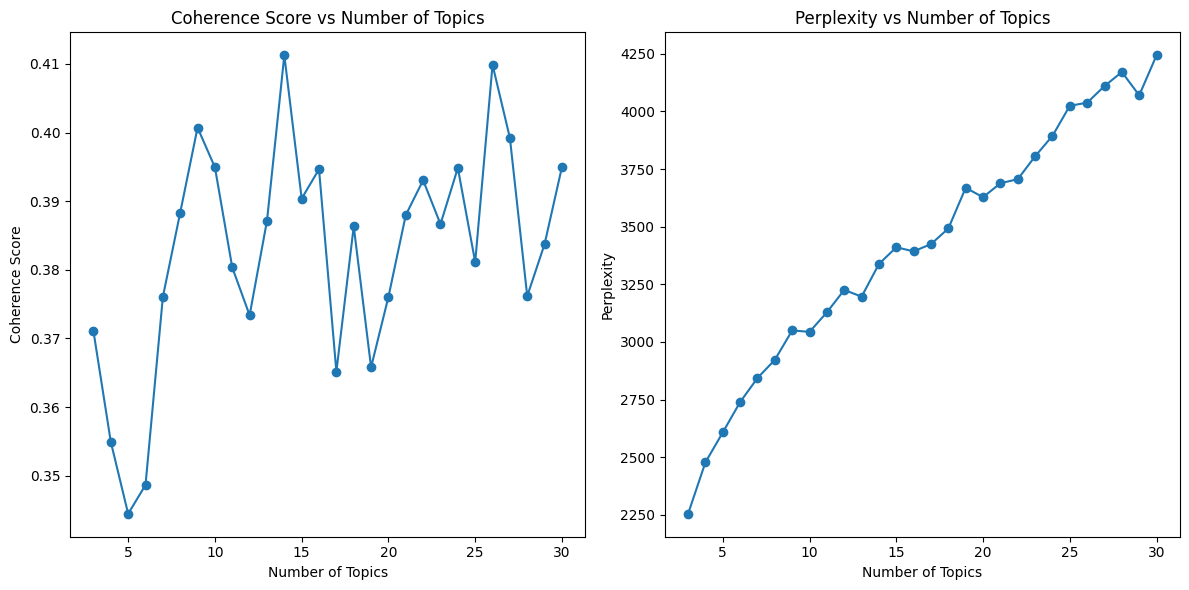

In [13]:
# graphque de la cohérence et de la perplexité
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(ks, coherences, marker='o')
plt.title('Coherence Score vs Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.subplot(1, 2, 2)
plt.plot(ks, perplexities, marker='o')
plt.title('Perplexity vs Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.tight_layout()
# plt.subplot(1, 2, 1)
# plt.plot(ks, log_vraissemblance, marker='o')
# plt.title('Log Likelihood vs Number of Topics')
# plt.xlabel('Number of Topics')
# plt.ylabel('Log Likelihood')
# plt.tight_layout()
plt.show()

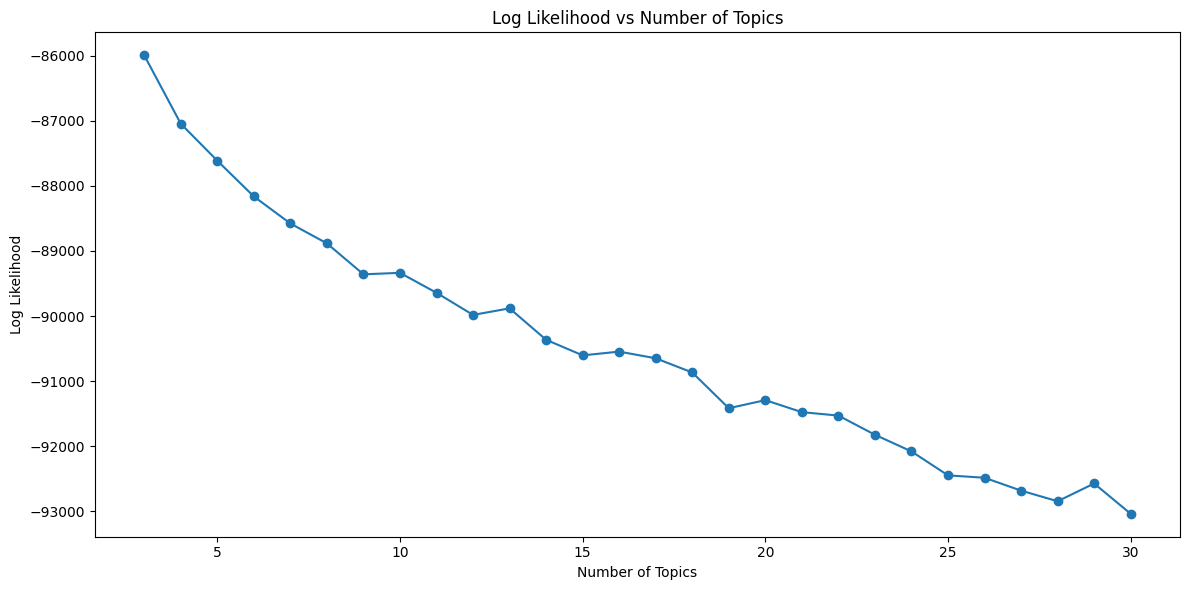

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(ks, log_vraissemblance, marker='o')
plt.title('Log Likelihood vs Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Log Likelihood')
plt.tight_layout()
plt.show()

In [11]:
# # selectionner le meilleur nombre de topics qui correspond au min de perplexité et au max de cohérence
# best_k = ks[np.argmax(coherences)]
# print(f'Le meilleur nombre de topics est {best_k} avec une cohérence de {max(coherences)} et une perplexité de {min(perplexities)}')

In [50]:
coherences_stock = []
perplexity_stock = []
seuils_stocks = []
for c in coherences:
    if c >= 0.4 and c <= 0.7:
        # print(c)
        coherences_stock.append(c)
        perplexity_stock.append(scores.get(c))
        seuils_stocks.append(c+scores.get(c))
        print(f'scrore de cohérence {c} assoicé au score de perplexité {scores.get(c)}, soit un seuil de {c+scores.get(c)}')

# trouver une formule pour trouver le nombre de topic optimal en se basant sur la somme entre cohérence et perplexity
seuil = 0.7 + min(perplexities)
print(f'le seuil {seuil}')

scrore de cohérence 0.40072406439680885 assoicé au score de perplexité 3050.0287265855736, soit un seuil de 3050.4294506499705
scrore de cohérence 0.41126572583310067 assoicé au score de perplexité 3338.1915979000287, soit un seuil de 3338.6028636258616
scrore de cohérence 0.4098794315591587 assoicé au score de perplexité 4037.6670482625923, soit un seuil de 4038.0769276941514
le seuil 2255.601018242916


In [44]:
min(perplexities) # 2254.901018242916

2254.901018242916

In [41]:
seuil = 0.7 + min(perplexities)
seuil

2255.601018242916

In [ ]:
diff

In [53]:
# # on selectionne le cohérences comprises entre 0.4 et 0.7 (plus c'est proche de 0.7 mieux c'est), tout en minimisant la perplexité
# coherences_stock = coherences
# best_ks =[]

# while True:
#     # bks = ks[np.argmax(coherences)]
#     bks = np.argmax(coherences)
#     print(bks)
#     if coherences[bks] >= 0.4 and coherences[bks] <= 0.7:
#         print(f'Le meilleur nombre de topics est {bks} avec une cohérence de {(coherences[bks])} ')
#         best_ks.append(bks)
#         coherences_stock = coherences_stock.remove(coherences_stock[bks])
#     else : 
#         print(f'L\'intervalle de topic ne peremt pas d\'obtenir une bonne cohérence entre 0.4 et 0.7')

# best_ks

0


TypeError: 'NoneType' object is not subscriptable

# gensim

In [4]:
# on créé un coprus à partir d'un texte (liste de listes de tokens)
corpus = [ doc for doc  in test1['tokens_clean_lem']]
dictionary = corpora.Dictionary(corpus)
# filtres les mots qui apparaissent dans moins de 20 documents ou plus de 50% des documents
dictionary.filter_extremes(no_below=20, no_above=0.5)

# Bag-of-words representation of the documents.
corpus_vect = [dictionary.doc2bow(doc) for doc in corpus]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus_vect))

# Entrainement 
# Set training parameters.
num_topics = 8
chunksize = 2000 # controls how many documents are processed at a time in the training algorithm. Increasing chunksize will speed up training, at least as long as the chunk of documents easily fit into memory
passes = 50 # controls how often we train the model on the entire corpus = “epochs”
iterations = 400 # is somewhat technical, but essentially it controls how often we repeat a particular loop over each document
# It is important to set the number of “passes” and “iterations” high enough.
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus_vect,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)


Number of unique tokens: 85
Number of documents: 1730


In [7]:

for (topic, words) in model.print_topics():
    print("***********")
    print("* topic", topic+1, "*")
    print("***********")
    print(topic+1, ":", words)
    print()

***********
* topic 1 *
***********
1 : 0.111*"video" + 0.094*"aimer" + 0.063*"arriere" + 0.060*"cheveux" + 0.054*"beaucoup" + 0.052*"genie" + 0.051*"rien" + 0.051*"vraiment" + 0.048*"adorer" + 0.046*"artiste"

***********
* topic 2 *
***********
2 : 0.266*"coupe" + 0.142*"vrai" + 0.136*"cheveux" + 0.096*"bien" + 0.090*"trop" + 0.061*"choquer" + 0.048*"temps" + 0.043*"jour" + 0.038*"nouveau" + 0.029*"gars"

***********
* topic 3 *
***********
3 : 0.409*"video" + 0.164*"faire" + 0.084*"creator" + 0.080*"tyler" + 0.068*"incroyable" + 0.036*"histoire" + 0.029*"more" + 0.027*"travail" + 0.023*"prochain" + 0.019*"jour"

***********
* topic 4 *
***********
4 : 0.138*"petit" + 0.107*"video" + 0.101*"prononcer" + 0.092*"clip" + 0.083*"film" + 0.076*"passer" + 0.060*"cool" + 0.058*"acteur" + 0.048*"plaisir" + 0.044*"voir"

***********
* topic 5 *
***********
5 : 0.241*"childish" + 0.178*"gambino" + 0.108*"video" + 0.061*"fois" + 0.058*"prononciation" + 0.047*"dernier" + 0.043*"falloir" + 0.041*

In [5]:
import pyLDAvis.gensim

# Prepare the visualization
LDAvis_prepared = pyLDAvis.gensim.prepare(model, corpus_vect, dictionary)

# Display the visualization (if running in a Jupyter Notebook)
pyLDAvis.display(LDAvis_prepared)
# lambda metrci de pertinance, proche de 1 fréquence élevé 0 exclusivitié
# rouge fréquence dans topic 
# bleu fréquence dans le corpus 

In [6]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Liste pour stocker les résultats
    topics_df = []

    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Topic dominant, % de contribution et mots-clés
        topic_num, prop_topic = row[0]
        topic_keywords = ", ".join([word for word, _ in ldamodel.show_topic(topic_num)])
        topics_df.append((i, int(topic_num), round(prop_topic, 4), topic_keywords, texts[i]))

    # Créer un DataFrame 
    df_topic_sents_keywords = pd.DataFrame(topics_df, columns=['Doc_ID', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Topic_Keywords', 'Text'])
    return df_topic_sents_keywords

In [7]:
res_lda = format_topics_sentences(ldamodel=model, corpus=corpus_vect, texts=df['tokens_clean_lem'])
res_lda.head()

,Doc_ID,Dominant_Topic,Topic_Perc_Contrib,Topic_Keywords,Text
0,0,0,0.4261,"faire, video, jamais, jour, entendre, america,...","['odoo', 'sponsor', 'decouvrir', 'odoo', 'cliq..."
1,1,7,0.5277,"creator, tyler, cheveux, arriere, chill, moche...","['video_sur', 'tyler_the_creator']"
2,2,2,0.1835,"video, trop, fois, bien, prononcer, passer, ad...","['mort_de_rire', 'disclaimer']"
3,3,1,0.7137,"donald, glover, voir, serie, community, voix, ...","['voir', 'serie', 'earn', 'alfred']"
4,4,2,0.1835,"video, trop, fois, bien, prononcer, passer, ad...","['reupload', 'impression', 'deja_vu', 'critiqu..."


In [70]:
res_lda['Topic_Keywords'].value_counts()

Topic_Keywords
video, incroyable, super, artiste, histoire, beaucoup, travail, vraiment, chill, clip        789
coupe, dire, vrai, fois, vouloir, rien, savoir, passer, choquer, nouveau                     189
video, faire, trop, creator, tyler, prononcer, adorer, ecouter, part, grand                  155
artiste, connaitre, vraiment, musique, interessant, decouvrir, genie, chose, cool, penser    155
childish, gambino, jamais, entendre, prononciation, album, video, gars, preferer, dernier    131
donald, glover, serie, community, regarder, america, atlanta, jour, acteur, film             118
bien, aimer, trouver, video, prochain, genial, ocean, frank, sujet, vrai                     108
cheveux, petit, arriere, voix, coiffure, falloir, moche, voir, aller, temps                   85
Name: count, dtype: int64

In [71]:
res_lda['Topic_Keywords'].unique()

array(['video, faire, trop, creator, tyler, prononcer, adorer, ecouter, part, grand',
       'video, incroyable, super, artiste, histoire, beaucoup, travail, vraiment, chill, clip',
       'donald, glover, serie, community, regarder, america, atlanta, jour, acteur, film',
       'cheveux, petit, arriere, voix, coiffure, falloir, moche, voir, aller, temps',
       'coupe, dire, vrai, fois, vouloir, rien, savoir, passer, choquer, nouveau',
       'artiste, connaitre, vraiment, musique, interessant, decouvrir, genie, chose, cool, penser',
       'childish, gambino, jamais, entendre, prononciation, album, video, gars, preferer, dernier',
       'bien, aimer, trouver, video, prochain, genial, ocean, frank, sujet, vrai'],
      dtype=object)

In [72]:
# Evaluate LDA model
coherence = gensim.models.CoherenceModel(model=model, texts=corpus, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence.get_coherence()
print(f"Coherence score: {coherence_lda}")

Coherence score: 0.3578775775115691


# recherhce du nombre de topic optimal

In [8]:
from gensim.models import LdaModel, CoherenceModel

def compute_coherence_values(dictionary, corpus, corpus_vect, start, limit, step):
    coherence_values_cv = []
    coherence_values_umass = []
    coherence_values_npmi = []
    perplexity_values = []
    model_list = []

    for num_topics in range(start, limit + 1, step):
        model = LdaModel(corpus=corpus,
                        id2word=dictionary,
                        alpha='auto',
                        eta='auto',
                        iterations=400,
                        num_topics=num_topics,
                        chunksize=2000,
                        passes=50,
                        eval_every=None
                        )
        model_list.append(model)

        cm_cv = CoherenceModel(model=model, texts=corpus, corpus=corpus_vect, dictionary=dictionary, coherence='c_v')
        coherence_values_cv.append(cm_cv.get_coherence())

        # Cohérence U_MASS
        cm_umass = CoherenceModel(model=model, texts=corpus, corpus=corpus_vect, dictionary=dictionary, coherence='u_mass')
        coherence_values_umass.append(cm_umass.get_coherence())

        # Cohérence NPMI
        cm_npmi = CoherenceModel(model=model, texts=corpus, corpus=corpus_vect, dictionary=dictionary, coherence='c_npmi')
        coherence_values_npmi.append(cm_npmi.get_coherence())

        # Perplexité
        perplexity_values.append(model.log_perplexity(corpus))

        # coherencemodel = CoherenceModel(model=model, corpus=corpus, texts=texts, dictionary=dictionary, coherence='c_v')
        # coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values_cv, coherence_values_umass, coherence_values_npmi, perplexity_values



In [13]:
# Paramètres
start = 3
limit = 30
step = 1

# Calcul des valeurs de cohérence
model_list, cv_scores, umass_scores, npmi_scores, perplexities = compute_coherence_values(dictionary=dictionary, corpus=corpus, corpus_vect=corpus_vect, start=start, limit=limit, step=step)

# Affichage des résultats
x = range(start, limit + 1, step)

# Affichage des scores de cohérence
for num_topics, cv, um, npmi, perp in zip(x, cv_scores, umass_scores, npmi_scores, perplexities):
    # print(f"Nombre de topics = {m}, Score de cohérence = {round(cv, 4)}")
    print(f"Topics={num_topics} | C_V={cv:.4f} | U_MASS={um:.4f} | NPMI={npmi:.4f} | Perplexité={perp:.4f}")


# Trouver le nombre optimal de topics
optimal_model_index = np.argmax(cv_scores)
optimal_num_topics = x[optimal_model_index]
print(f"Nombre optimal de topics : {optimal_num_topics} avec un score de cohérence de {cv_scores[optimal_model_index]}")
# Affichage du modèle optimal
optimal_model = model_list[optimal_model_index]

ValueError: too many values to unpack (expected 2)

# BERTopic

# LLM INTERPRETATION

In [139]:
# from huggingface_hub import InferenceClient

# HF_token = open("../token_hf.txt", "r").read().strip()
# client = InferenceClient(
#     provider="novita",
#     api_key=HF_token,
# )

# completion = client.chat.completions.create(
#     model="mistralai/Mistral-7B-Instruct-v0.3",
#     messages=[
#         {"role": "system", 
#         "content": "Tu es un data scientist spécialisé en NLP."},
#         {
#             "role": "user ",
#             "content": " Résume en un mots les mots clés suivants : " + res_lda['Topic_Keywords'].unique()
#         }
#     ],temperature=0.0
# )

# print(completion.choices[0].message)

TypeError: Object of type ndarray is not JSON serializable

In [142]:
# for i in res_lda['Topic_Keywords'].value_counts().index.tolist():
#     print("________________Topic Keywords:", i)
#     completion = client.chat.completions.create(
#     model="mistralai/Mistral-7B-Instruct-v0.3",
#     messages=[
#         {"role": "system", 
#         "content": "Tu es un data scientist spécialisé en NLP."},
#         {
#             "role": "user ",
#             "content": " Nomme le sujet identifié par le modèle en te basant sur les mots suivants: " + i
#         }
#     ], temperature=0.0
# )
#     print(completion.choices[0].message.content)

________________Topic Keywords: vidéo, coupe, cheveux, childish, gambino, artiste, arrière, bien, super, faire
The subject identified by the model is "Childish Gambino, Artist, Rear View, Good, Super, Haircut, Video"

________________Topic Keywords: vidéo, faire, bien, incroyable, série, glover, childish, vraiment, donald, atlanta
 The subject identified by the model is a childish series called "Atlanta" featuring Donald Glover.

________________Topic Keywords: vidéo, tyler, creator, artiste, vraiment, faire, super, bien, video, trop
The subject identified by the model based on the given words is "creator" or "artiste".

________________Topic Keywords: vidéo, artiste, bien, trop, dire, faire, connaître, film, histoire, voir
 The subject identified by the model based on the given words could be a movie, artist, piece of art, film, story, or history that is too difficult to understand or know about without seeing it.

________________Topic Keywords: vidéo, chill, artiste, dish, kendrick,